In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [2]:
mental_health = pd.read_csv('survey.csv')
mental_health.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [3]:
mental_health.dropna(subset=['work_interfere'], inplace=True)
mental_health.info()
mental_health.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 995 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  995 non-null    object
 1   Age                        995 non-null    int64 
 2   Gender                     995 non-null    object
 3   Country                    995 non-null    object
 4   state                      602 non-null    object
 5   self_employed              977 non-null    object
 6   family_history             995 non-null    object
 7   treatment                  995 non-null    object
 8   work_interfere             995 non-null    object
 9   no_employees               995 non-null    object
 10  remote_work                995 non-null    object
 11  tech_company               995 non-null    object
 12  benefits                   995 non-null    object
 13  care_options               995 non-null    object
 14  wellness_progr

Timestamp                      0
Age                            0
Gender                         0
Country                        0
state                        393
self_employed                 18
family_history                 0
treatment                      0
work_interfere                 0
no_employees                   0
remote_work                    0
tech_company                   0
benefits                       0
care_options                   0
wellness_program               0
seek_help                      0
anonymity                      0
leave                          0
mental_health_consequence      0
phys_health_consequence        0
coworkers                      0
supervisor                     0
mental_health_interview        0
phys_health_interview          0
mental_vs_physical             0
obs_consequence                0
comments                     852
dtype: int64

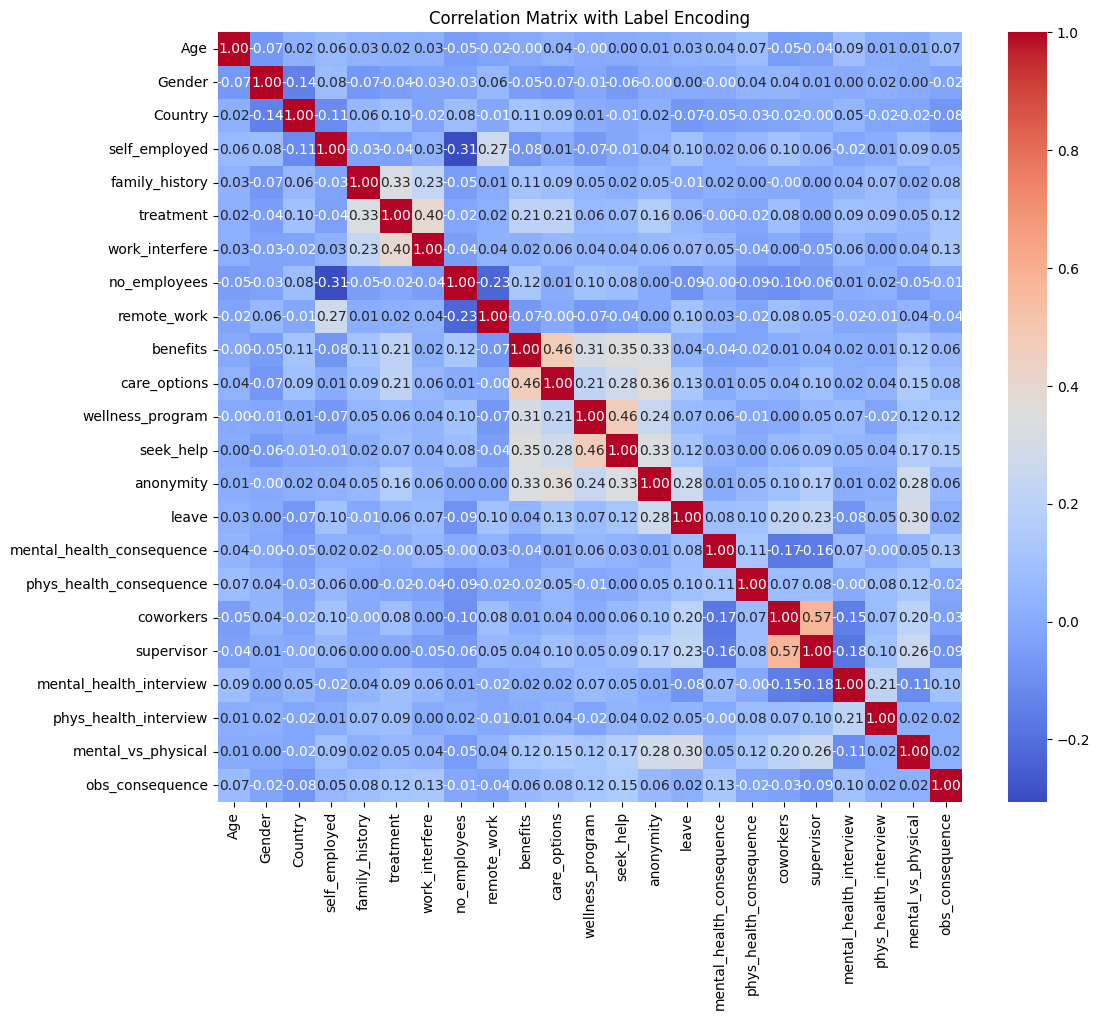

In [4]:
cols_to_drop = ['Timestamp', 'comments', 'state', 'tech_company']
works_in_tech_encoded = mental_health.drop(columns=cols_to_drop)
for col in works_in_tech_encoded.columns:
	if col == 'work_interfere':
		works_in_tech_encoded[col] = works_in_tech_encoded[col].map({
			'Often': 1, 'Sometimes': 1,
			'Rarely': 0, 'Never': 0
		})
	elif works_in_tech_encoded[col].dtype == 'object':
		works_in_tech_encoded[col] = LabelEncoder().fit_transform(works_in_tech_encoded[col])
corr = works_in_tech_encoded.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix with Label Encoding")
plt.show()

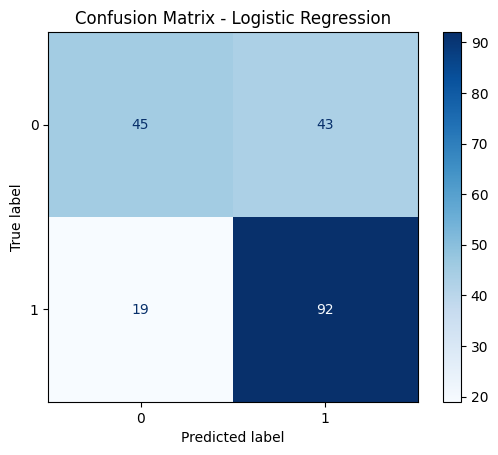

              precision    recall  f1-score   support

           0       0.70      0.51      0.59        88
           1       0.68      0.83      0.75       111

    accuracy                           0.69       199
   macro avg       0.69      0.67      0.67       199
weighted avg       0.69      0.69      0.68       199



In [5]:
# --- Features & Target ---
features = ['Age', 'family_history', 'treatment', 'leave', 'care_options', 'Country']
target = 'work_interfere'  # Yes / No

# X and y
X = mental_health[features].copy()
y = mental_health[target].map({
    'Often': 1, 'Sometimes': 1,   # collapse into 1
    'Rarely': 0, 'Never': 0,       # collapse into 0
})

# --- One-Hot Encode categorical column ---
# X = pd.get_dummies(X, drop_first=True)
for col in X.columns:
	X[col] = LabelEncoder().fit_transform(X[col])
# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Train Logistic Regression ---
model = LogisticRegression(max_iter=1000)  # increase iterations just in case
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# --- Classification Report ---
print(classification_report(y_test, y_pred))